In [2]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astroplan import Observer
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import pandas as pd
#from __future__ import (absolute_import, division, print_function, unicode_literals)
from astropy.coordinates import get_moon, get_sun, solar_system_ephemeris, angular_separation



In [3]:
global sch_id,item_name,tel_code,ob_id,execution_time,ra,dec,instrument,rank_class,seeing,sky_transparency,airmass,moon_distance,fli, OBstatus, OBgrade



#df = pd.read_csv('SMTSqueues/queue_dump_2022-04-01.csv')
df = pd.read_csv('SMTSqueues/queue_dump_2021+2022-04-01.csv')



sch_id=np.array(df['sch_id'])
item_name=np.array(df['item_name'])
tel_code=np.array(df['tel_code'])
ob_id =np.array(df['ob_id'])
execution_time=np.array(df['execution_time'])
ra=np.array(df['ra'])
dec=np.array(df['dec'])
instrument=np.array(df['instrument'])
rank_class=np.array(df['rank_class'])
seeing=np.array(df['seeing'])
sky_transparency=np.array(df['sky_transparency'])
airmass=np.array(df['airmass'])
moon_distance=np.array(df['moon_distance'])
fli=np.array(df['fli'])




OBstatus=[]
OBgrade=[]
for i in range(0,len(ob_id)):
    OBstatus.append('+')
    OBgrade.append('nan')
    
OBstatus=np.array(OBstatus)
OBgrade=np.array(OBgrade)





ob_id=ob_id.astype('int')
execution_time=execution_time.astype('float')
ra=ra.astype('float')
dec=dec.astype('float')
#ra = np.array([item.strip() for item in ra])
#dec= np.array([item.strip() for item in dec])
tel_code=tel_code.astype('str')
tel_code= np.array([item.strip() for item in tel_code])
instrument=instrument.astype('str')
instrument = np.array([item.strip() for item in instrument])
rank_class=rank_class.astype('str')
rank_class = np.array([item.strip() for item in rank_class])
seeing=seeing.astype('float')
sky_transparency=sky_transparency.astype('str')
sky_transparency = np.array([item.strip() for item in sky_transparency])
airmass=airmass.astype('float')
moon_distance=moon_distance.astype('float')
fli=fli.astype('float')


moon_distance=moon_distance/(3600.0*1000.0)   ### moon distance in deg
ra=ra/(3600.0*1000.0)   ## ra in deg
dec=dec/(3600.0*1000.0)   ## dec in deg

print(airmass)

[2.8 2.8 2.8 ... 1.6 1.4 1.6]


## Queue stats

In [4]:

totaltime=0

intall=np.where( ((instrument=='FORS2') | (instrument=='KMOS')) & ((rank_class=='A' ) | (rank_class=='B' )) )

for i in intall[0]:
    totaltime=totaltime +execution_time[i]




print(totaltime/3600)

1139.3955555555556


In [5]:

##FWHM_IQ = Resulting IQ for a given ORANG seeing input (FWHM_ORANG), and the current airmass and the bluest filter λ
def FWHMIQ(FWHM_ORANG, instrument, insfilter, airmass):

    f=open('ins_filt_lc_fwhm.txt')
    for line in f:
        if instrument in line:
            filt=line.split()[1]
            if insfilter==filt:
                lc=float(line.split()[2])
                FWHM_INS=float(line.split()[3])
               # print (filt, lc, FWHM_INS)
    f.close()
    
    #lc=2.0
    lc=lc*1e3
    

    L_0 = 46 #m
    F_Kolb = -0.982  ## VLT
    AO_GAIN = 1.0
    r_0 = 0.976 * 500.0e-9/FWHM_ORANG*((180/np.pi)*3600)* (lc/500)**1.2 * (airmass**(-3/5))
    #print('r0', r_0)
    
    FWHM_ATM = FWHM_ORANG * (lc/500)**(-1/5) * airmass**(3/5) * (1 + F_Kolb * 2.182 * (r_0/L_0)**0.356)**0.5
    

    if (1+F_Kolb * 2.182 * (r_0/L_0)**0.356) < 0:
        FWHM_ATM = 0

    FWHM_TEL = 0.000212 * lc / 8.2  ## VLT
    
                                        
    FWHM_IQ =  ((FWHM_ATM/AO_GAIN)**2.0 + FWHM_TEL**2.0 + FWHM_INS**2.0)**0.5
                                         
                                         
    return FWHM_IQ




def FWHMIQarray(FWHM_ORANG, instrument, insfilter, airmass):

    f=open('ins_filt_lc_fwhm.txt')
    for line in f:
        if instrument in line:
            filt=line.split()[1]
            if insfilter==filt:
                lc=float(line.split()[2])
                FWHM_INS=float(line.split()[3])
               # print (filt, lc, FWHM_INS)
    f.close()
    
    #lc=2.0
    lc=lc*1e3
    

    L_0 = 46 #m
    F_Kolb = -0.982  ## VLT
    AO_GAIN = 1.0
    r_0 = 0.976 * 500.0e-9/FWHM_ORANG*((180/np.pi)*3600)* (lc/500)**1.2 * (airmass**(-3/5))
    #print('r0', r_0)
    
    FWHM_ATM = FWHM_ORANG * (lc/500)**(-1/5) * airmass**(3/5) * (1 + F_Kolb * 2.182 * (r_0/L_0)**0.356)**0.5   


    ind=np.where((1+F_Kolb * 2.182 * (r_0/L_0)**0.356)<0)
    FWHM_ATM[ind]=0

    #if (1+F_Kolb * 2.182 * (r_0/L_0)**0.356) < 0:
     #   FWHM_ATM = 0

    FWHM_TEL = 0.000212 * lc / 8.2  ## VLT
    FWHM_IQ =  ((FWHM_ATM/AO_GAIN)**2.0 + FWHM_TEL**2.0 + FWHM_INS**2.0)**0.5                                     
                                         
    return FWHM_IQ

                                         
FWHMIQ(0.83, 'FORS2', 'R_SPECIAL', 1.1)
FWHMIQ(0.83, 'KMOS', 'H,H,H', 1.1)
FWHMIQ(0.83, 'XSHOOTER', 'R', 1.1)


def obDIMM2IQanalysis(starttime, endtime, requirementdimm, INS, insfilter, airmass, plotbool=False):
    

    starttimejdt = Time(starttime, format='isot', scale='utc').to_value('jd')
    endtimejdt = Time(endtime, format='isot', scale='utc').to_value('jd')


    obseconds=np.arange(starttimejdt, endtimejdt+1/86400, 1/86400)
    dimmsec=np.interp(obseconds, dimmtjd, dimm)
    #print (dimmsec)
    #dimmsec=AirmassFilterInsSeeing2IQ(OBIDin, starttime, INS, dimmsec)[0]
    #print (dimmsec)
    dimmsec= FWHMIQarray(dimmsec, INS, insfilter, airmass)


    #print(starttimejdt)

    dimmavg=np.mean(dimmsec)
    dimmstd=np.std(dimmsec)
    dimmmin=np.min(dimmsec)
    dimmmax=np.max(dimmsec)


    duration=(endtimejdt-starttimejdt)*86400

    aboveAreqint=np.where(dimmsec>requirementdimm)
    aboveAreqduration=len(aboveAreqint[0])


    aboveBreqint=np.where(dimmsec>requirementdimm*1.1)
    aboveBreqduration=len(aboveBreqint[0])
    
    
    
    
    
    tenminbeforestarttimejdt = Time(starttime, format='isot', scale='utc').to_value('jd')-0.00694
    starttimejdt = Time(starttime, format='isot', scale='utc').to_value('jd')
    obseconds2=np.arange(tenminbeforestarttimejdt, starttimejdt+1/86400, 1/86400)
    dimmsec2=np.interp(obseconds2, dimmtjd, dimm)
    precast10min=np.median(dimmsec2)
  
    
    

#    print(duration)
    if plotbool==True:
        plt.plot(obseconds, dimmsec)
        plt.plot(obseconds2, dimmsec2)
        plt.plot(obseconds[aboveAreqint], dimmsec[aboveAreqint], '.g')
        plt.plot(obseconds[aboveBreqint], dimmsec[aboveBreqint], '.r')
        plt.plot(obseconds2, np.ones(len(obseconds2))*precast10min, color='orange')
        plt.plot(obseconds, np.ones(len(obseconds))*requirementdimm, color='blue')
        plt.plot(obseconds, np.ones(len(obseconds))*dimmavg, color='red')
        plt.xlabel('\nJD')
        plt.ylabel('DIMM (arcsec)')
        plt.show()
    
    
    return np.round(dimmavg,2), np.round(dimmstd,2), np.round(dimmmin,2), np.round(dimmmax,2), np.round(duration,1), np.round(aboveAreqduration,1), np.round(aboveBreqduration,1), np.round(aboveAreqduration/duration,2), np.round(aboveBreqduration/duration,2), np.round(precast10min,2)



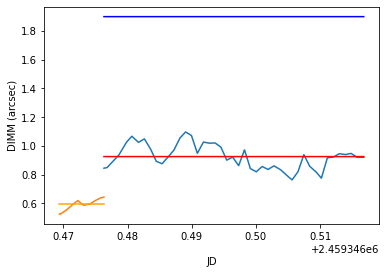

(0.93, 0.08, 0.76, 1.1, 3499.0, 0, 0, 0.0, 0.0, 0.6)

In [7]:
obDIMM2IQanalysis('2021-05-11T23:25:53.679', '2021-05-12T00:24:12.680', 1.9 ,'XSHOOTER', 'R' ,1.482, plotbool=True)
##  return round(dimmavg,2), round(dimmstd,2), round(dimmmin,2), round(dimmmax,2), round(duration,1), round(aboveAreqduration,1), round(aboveBreqduration,1), round(aboveAreqduration/duration,2), round(aboveBreqduration/duration,2), round(precast10min,2)






2021-01-01T00:14:13


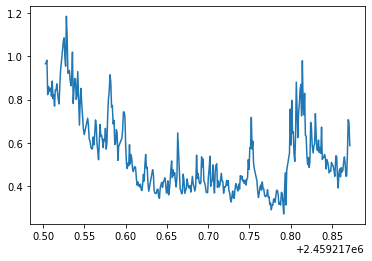

2021-01-01T00:45:11
nowcast60 nan
0.7


In [6]:

global dimmtimes, dimm
dimmtimes, dimm=np.genfromtxt("weather/wdb_query_1980_eso.csv",skip_header=3, skip_footer=7, delimiter=',', dtype='str', unpack=True, usecols=(0,1))
print(dimmtimes[0])
dimm=dimm.astype('float')
dimmt = Time(dimmtimes, format='isot', scale='utc')
dimmtjd=dimmt.to_value('jd')
#print(dimmtjd[0])


ind=np.where((dimmtjd>2459217.0) & (dimmtjd<2459218.0))
plt.plot(dimmtjd[ind], dimm[ind])
plt.show()



def precast10min(starttime):
    
    starttimejdt = Time(starttime, format='isot', scale='utc').to_value('jd')
   
    tenminbeforestarttimejdt = Time(starttime, format='isot', scale='utc').to_value('jd')-0.00694
    starttimejdt = Time(starttime, format='isot', scale='utc').to_value('jd')
    obseconds2=np.arange(tenminbeforestarttimejdt, starttimejdt+1/86400, 1/86400)
    dimmsec2=np.interp(obseconds2, dimmtjd, dimm)
    precast10min=np.median(dimmsec2)
      
    return np.round(precast10min,2)





global datetime_60,seeing_pred_60, datetime_30,seeing_pred_30, datetime_Angel, SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST01, SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02

## Fuyan nowcast
datetime_60,seeing_pred_60=np.genfromtxt("Fuyan_nowcast/nowcast_pred_1h.csv",skip_header=1, skip_footer=0, delimiter=',', dtype='str', unpack=True, usecols=(1,2))
datetime_30,seeing_pred_30=np.genfromtxt("Fuyan_nowcast/nowcast_pred_30min.csv",skip_header=1, skip_footer=0, delimiter=',', dtype='str', unpack=True, usecols=(1,2))

for i in range(0, len(datetime_60)):
    datetime_60[i]=datetime_60[i].replace(' ','T').strip()
    if seeing_pred_60[i].strip()=='':
        seeing_pred_60[i]='nan' 
seeing_pred_60=seeing_pred_60.astype('float')


for i in range(0, len(datetime_30)):
    datetime_30[i]=datetime_30[i].replace(' ','T').strip()
    if seeing_pred_30[i].strip()=='':
        seeing_pred_30[i]='nan' 
seeing_pred_30=seeing_pred_30.astype('float')




# ## Angel nowcast
# YEAR,MONTH,DAY,H,M,S,SEEING0,SEEING_OBSERVEDAverageNext1Hr,SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST01,SEEING_PREDICTED_AverageNext1Hr_LSTM_ML,SEEING_PREDICTED_AverageNext1Hr_StationaryModel,SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02=np.genfromtxt("Angel_nowcast/PAO_2021_seeing_nowcast_RF_LSTM_SM_01.csv",skip_header=1, skip_footer=0, delimiter=',', dtype='str', unpack=True, usecols=(0,1,2,3,4,5,6,7,8,9,10,11))
# datetime_Angel=[]
# for i in range(0, len(YEAR)):
#     datetime_Angel.append(YEAR[i]+'-'+MONTH[i].zfill(2)+'-'+DAY[i].zfill(2)+'T'+H[i].zfill(2)+':'+M[i].zfill(2)+':'+S[i].zfill(2))
# datetime_Angel=np.array(datetime_Angel)

# print(datetime_Angel[10])
# for i in range(0, len(SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02)):
#     if SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02[i].strip()=='NaN':
#         SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02[i]='nan' 
# SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02=SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02.astype('float')


## Angel nowcast
YEAR,MONTH,DAY,H,M,S,SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02=np.genfromtxt("Angel_nowcast/PAO_2021_seeing_nowcast_RF_scheduling_simulations_20220319.csv",skip_header=1, skip_footer=0, delimiter=',', dtype='str', unpack=True, usecols=(3,4,5,6,7,8,41))
datetime_Angel=[]
for i in range(0, len(YEAR)):
   # print(int(float(YEAR[i])))
    datetime_Angel.append(str(int(float(YEAR[i])))+'-'+str(int(float(MONTH[i]))).zfill(2)+'-'+str(int(float(DAY[i]))).zfill(2)+'T'+str(int(float(H[i]))).zfill(2)+':'+str(int(float(M[i]))).zfill(2)+':'+str(int(float(S[i]))).zfill(2))
datetime_Angel=np.array(datetime_Angel)

print(datetime_Angel[10])
for i in range(0, len(SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02)):
    if SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02[i].strip()=='NaN':
        SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02[i]='nan' 
SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02=SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02.astype('float')




def nowcast60(dattime):
    #print (dattime)
    #print(np.where(datetime_60==dattime)[0][0])
    #seeing = seeing_pred_60[np.where(datetime_60==dattime)[0][0]]
    seeing = seeing_pred_60[datetime_60==dattime]
        
    if len(seeing)==0:   
        dtjd = Time(dattime, format='isot', scale='utc').to_value('jd')
        datetime_60jd=Time(datetime_60, format='isot', scale='utc').to_value('jd')
        pos=np.where(abs(datetime_60jd-dtjd)==min(abs(datetime_60jd-dtjd)))
        #print (pos)
        seeing =  seeing_pred_60[pos]

    return seeing

def nowcast30(dattime):
    #print (dattime)
    #print(np.where(datetime_60==dattime)[0][0])
    #seeing = seeing_pred_60[np.where(datetime_60==dattime)[0][0]]
    seeing = seeing_pred_30[datetime_30==dattime]
    
    if len(seeing)==0:   
        dtjd = Time(dattime, format='isot', scale='utc').to_value('jd')
        datetime_30jd=Time(datetime_30, format='isot', scale='utc').to_value('jd')
        pos=np.where(abs(datetime_30jd-dtjd)==min(abs(datetime_30jd-dtjd)))
        #print (pos)
        seeing =  seeing_pred_30[pos]

    return seeing

def nowcastRT(dattime):
    #print (dattime)
    #print(np.where(datetime_60==dattime)[0][0])
    #seeing = seeing_pred_60[np.where(datetime_60==dattime)[0][0]]
    seeing = SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02[datetime_Angel==dattime]
    if len(seeing)==0:   
        dtjd = Time(dattime, format='isot', scale='utc').to_value('jd')
        datetime_Angeljd=Time(datetime_Angel, format='isot', scale='utc').to_value('jd')
        pos=np.where(abs(datetime_Angeljd-dtjd)==min(abs(datetime_Angeljd-dtjd)))
        #print (pos)
        seeing = SEEING_PREDICTED_AverageNext1Hr_RF_ML_TEST02[pos]
    return seeing

print('nowcast60', nowcast60('2021-04-01T02:44:05')[0])
#print('nowcastRT', nowcastRT('2021-01-14T02:44:05'))
if str(nowcast60('2021-04-01T02:44:05')[0])=='nan':
    print('0.7')




In [8]:
temp='g,N, MJD,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,P0,T30M,T2M,TDEW30M,RH30M,WD30M,WD10M,WS30M,WS10M,WDRMS30M,WDRMS10M,WSMAX30M,WSRMS30M,WSMAX10M,WSRMS10M,FREEATMSEEING,MASS_TAU0,MASS_TETHA0,GLG,MASSDIMM_SEEING,MASSDIMM_TAU0,MASSDIMM_TETHA0,MASSDIMM_TURB_ALT,MASSDIMM_TURB_VEL,RiC,WindC,SEEING_AZ,SEEING_EL,SEEING_REL_FLUX_RMS,SEEING0,SUN_EL,SEEING_OBSERVED,SEEING_PREDICTED,FRACTIONAL_PREDICTION_ERROR'
temp=temp.split(',')
print(temp[3], temp[4], temp[5], temp[6], temp[7], temp[8], temp[41])

YEAR MONTH DAY HOUR MINUTE SECOND SEEING_PREDICTED


In [9]:

global transparency_start_ut,transparency_end_ut,transparency_PH,transparency_CL,transparency_TN,transparency_TK,transparency_CY,transparency_WI,transparency_HU,transparency_RN,transparency_SN,transparency_EQ,transparency_OT

transparency_start_ut,transparency_end_ut,transparency_PH,transparency_CL,transparency_TN,transparency_TK,transparency_CY,transparency_WI,transparency_HU,transparency_RN,transparency_SN,transparency_EQ,transparency_OT=np.genfromtxt("weather/weatherlog-VISTA-clean.csv",skip_header=1, skip_footer=2, delimiter=',', dtype='str', unpack=True, usecols=(0,1,2,3,4,5,6,7,8,9, 10,11,12))
#print(transparency_start_ut)
#dimm=dimm.astype('float')
transparency_start_ut_t = Time(transparency_start_ut, format='isot', scale='utc')
transparency_start_ut_jd=transparency_start_ut_t.to_value('jd')

transparency_end_ut_t = Time(transparency_end_ut, format='isot', scale='utc')
transparency_end_ut_jd=transparency_end_ut_t.to_value('jd')

#print(transaorency_start_ut)
#print(transparency_start_ut_jd[2000])

transparency_PH=transparency_PH.astype('int')
transparency_CL=transparency_CL.astype('int')
transparency_TN=transparency_TN.astype('int')
transparency_TK=transparency_TK.astype('int') 
transparency_CY=transparency_CY.astype('int')
transparency_WI=transparency_WI.astype('int')
transparency_HU=transparency_HU.astype('int')
transparency_RN=transparency_RN.astype('int')
transparency_SN=transparency_SN.astype('int')
transparency_EQ=transparency_EQ.astype('int')
transparency_OT=transparency_OT.astype('int')




def current_transparency(utjd):
    transparency='CLR'   ### default value

    ind=np.where((transparency_start_ut_jd < utjd ))[0][-1]
    
    if transparency_CY[ind]==1:
        transparency='TelClosed'
    if transparency_WI[ind]==1:
        transparency='TelClosed'
    if transparency_HU[ind]==1:
        transparency='TelClosed'
    if transparency_RN[ind]==1:
        transparency='TelClosed'
    if transparency_SN[ind]==1:
        transparency='TelClosed'
    if transparency_EQ[ind]==1:
        transparency='TelClosed'
    if transparency_OT[ind]==1:
        transparency='TelClosed'
    ### note that previous transaprency gets overwritten if more than one condition is fulfilled (e.g. WI and CLR)
    if transparency_PH[ind]==1:
        transparency='PHO'
    if transparency_CL[ind]==1:
        transparency='CLR' 
    if transparency_TN[ind]==1:
        transparency='THN'
    if transparency_TK[ind]==1:
        transparency='THK'

    #print(transparency_start_ut_jd[ind],transparency_end_ut[ind],transparency_PH[ind])
    return transparency

current_transparency(2456302.83)

#plt.plot(dimmtjd[ind], dimm[ind])
#plt.show()

'TelClosed'

In [10]:

sunsettime=2459217.5
sunrisetime=2459218.5
indli=np.where((transparency_start_ut_jd > sunsettime-0.2 ) & (transparency_end_ut_jd < sunrisetime+0.2 ) )[0]


print(ind)
for ind in indli:
    
    if transparency_CY[ind]==1:
        transparency='CY'
    if transparency_WI[ind]==1:
        transparency='WI'
    if transparency_HU[ind]==1:
        transparency='HU'
    if transparency_RN[ind]==1:
        transparency='RN'
    if transparency_SN[ind]==1:
        transparency='SN'
    if transparency_EQ[ind]==1:
        transparency='EQ'
    if transparency_OT[ind]==1:
        transparency='OT'
    ### note that previous transaprency gets overwritten if more than one condition is fulfilled (e.g. WI and CLR)
    if transparency_PH[ind]==1:
        transparency='PHO'
    if transparency_CL[ind]==1:
        transparency='CLR' 
    if transparency_TN[ind]==1:
        transparency='THN'
    if transparency_TK[ind]==1:
        transparency='THK'

    print(transparency_start_ut_jd[ind], transparency_end_ut_jd[ind], transparency)
#ind=np.where((dimmtjd>2459217.0) & (dimmtjd<2459218.0))
#plt.plot(dimmtjd[ind], dimm[ind])
#plt.show()


(array([ 776,  777,  778,  779,  780,  781,  782,  783,  784,  785,  786,
        787,  788,  789,  790,  791,  792,  793,  794,  795,  796,  797,
        798,  799,  800,  801,  802,  803,  804,  805,  806,  807,  808,
        809,  810,  811,  812,  813,  814,  815,  816,  817,  818,  819,
        820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,
        831,  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,
        842,  843,  844,  845,  846,  847,  848,  849,  850,  851,  852,
        853,  854,  855,  856,  857,  858,  859,  860,  861,  862,  863,
        864,  865,  866,  867,  868,  869,  870,  871,  872,  873,  874,
        875,  876,  877,  878,  879,  880,  881,  882,  883,  884,  885,
        886,  887,  888,  889,  890,  891,  892,  893,  894,  895,  896,
        897,  898,  899,  900,  901,  902,  903,  904,  905,  906,  907,
        908,  909,  910,  911,  912,  913,  914,  915,  916,  917,  918,
        919,  920,  921,  922,  923,  924,  925,  

In [11]:

def targetAiramssAtEndOfOB(ra,dec,JDtimenow,durationsec):
    time = Time(JDtimenow, format='jd', scale='utc')
    endtimejdt = Time(float(JDtimenow)+(float(durationsec)/86400) , format='jd', scale='utc')
    cobj = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
    cobjaltazs = cobj.transform_to(AltAz(obstime=endtimejdt, location=paranal))
    #print (endtimejdt.iso, cobjaltazs.secz)
    return cobjaltazs.secz

def interpolatePseeing(seeing):
    x=np.array([0.15	,0.2026534077649148,0.2647453375570789,0.3268212740418699,0.3888481875627568,0.4463148065052318,0.5022560705742722,0.5521652365246894,0.6007603246674107,0.6386709500217624,0.6695766574050621,0.6987309064789939,0.747175944563252, 0.7971052764008069,0.8470741755100122,0.8999943822635501,0.961792033544429, 1.0236934840391536,1.0856112258531898,1.1475341828761518,1.2094919079586206,1.2715101294646307,1.333528350970641, 1.3955587412974786,1.4575992143615728,1.519650117843519, 1.5817065842149867,1.6437793915744217,1.7058605432681393,1.7679455194484017,1.8300315386704495,1.8921071274746457,1.9541934943772885,2.0044518476697846])
    y=np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10586048534215764, 0.1788076449874847, 0.24839679780461732, 0.32591956217385765, 0.3821030079334775, 0.4391220221961387, 0.5091564493091792, 0.5780200168090953, 0.6388712117998104, 0.7008798596722923, 0.7615977433355929, 0.8012962861951024, 0.837695836894004, 0.873039307785394, 0.9013422466267063, 0.9173946597008833, 0.9334470727750604, 0.9470352996317104, 0.9585817721938378, 0.9680160851409418, 0.9763239129600335, 0.9813226907155886, 0.9846317407791252, 0.9871663323171531, 0.9894897078936787, 0.9939252430852277, 0.9961782133412526, 1.0])
    yinterp = np.interp(seeing, x, y)
    return yinterp
#print(interpolatePseeing(1.0))

def interpolatePfli(fli):
    x=np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    y=np.array([0.510,0.532,0.556,0.581,0.610,0.641,0.678,0.722,0.779,0.867,1.000])
    yinterp = np.interp(fli, x, y)
    return yinterp
#print(interpolatePfli(0.45))






def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    i : `~astropy.units.Quantity`
        Phase angle of the moon [radians]
    """
    # TODO: cache these sun/moon SkyCoord objects

    sun = get_sun(time)
    moon = get_moon(time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance*np.sin(elongation),
                      moon.distance - sun.distance*np.cos(elongation))  ####.to(u.deg)




def moon_illumination(time, ephemeris=None):
    """
    Calculate fraction of the moon illuminated.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    k : float
        Fraction of moon illuminated
    """
    i = moon_phase_angle(time, ephemeris=ephemeris)
    k = (1 + np.cos(i))/2.0
    return k.value



def MoonDistance(MoonSC, targra, targdec):
    return angular_separation(MoonSC.ra.rad, MoonSC.dec.rad, targra/(180.0/np.pi), targdec/(180.0/np.pi))*(180.0/np.pi)


#print(MoonDistance(MoonSC, 168.77613783678663 ,5.760202885035716))

###### ranking functions

def Psky(transparency):
    if transparency=='PHO':
        p=0.5
    if transparency=='CLR':
        p=0.8
    if transparency=='THN':
        p=0.9
    if transparency=='THK':
        p=0.95
    return p



def Pz(zreq, targdec):
    altrad = np.arcsin(1/zreq)
    altdeg = altrad * (180.0/np.pi)
    latdeg = -24.625
    latrad = latdeg* np.pi/180
    targdecrad = targdec * np.pi/180
    arg = ( np.sin(altrad) - np.sin(latrad) *np.sin(targdecrad)) / (np.cos(latrad)*np.cos(targdecrad) )
    #// prevent invalid calls to acos
    if abs(arg) > 1:
        hz = 0
    else:
        hz = 12.0/np.pi * np.arccos(arg)
    #// normalize by the tracking time at airmass limit 1.7 and δ = lat, i.e.
    #// 2*hz(zreq=1.7, δ = lat) = 7.986 hours
    Pzr = 2.0 * hz / 7.986 ##hours
    return Pzr

#print(Pz(1.72, -24.625))



def Pset(zreq, targra, targdec, dateofnight):
    altrad = np.arcsin(1/zreq)
    altdeg = altrad * (180.0/np.pi)
    latdeg = -24.625
    latrad = latdeg* np.pi/180
    targdecrad = targdec * np.pi/180
    arg = ( np.sin(altrad) - np.sin(latrad) *np.sin(targdecrad)) / (np.cos(latrad)*np.cos(targdecrad) )
    #// prevent invalid calls to acos
    if abs(arg) > 1:
        hz = 0
    else:
        hz = 12.0/np.pi * np.arccos(arg)


    td = Time(dateofnight+'T12:00:00.0', scale='utc', location=('-70.4039d', '-24.6272d'))
    eveningtwilighttjd=float(paranalObserver.twilight_evening_astronomical(td, which='next', n_grid_points=150).jd)
 

    eveningtwilightt = Time(eveningtwilighttjd, format='jd', scale='utc', location=('-70.4039d', '-24.6272d'))   
    STdusk= eveningtwilightt.sidereal_time('mean').hour 
    #print (STdusk)

    hdusk = targra/15.0 - STdusk
    if (hdusk <= -12.0):
        hdusk += 24.0
    if (hdusk >= 12.0):
        hdusk -= 24.0
    if (hz > hdusk):
        Pset = (hz + hdusk) / (2 * hz)
    else:
        Pset = 1.0
    if Pset < 0.0:
        Pset = 0.0

    return Pset


#print(Pset(1.72, 11*15.0, -24.625,  '2022-05-11'))


#Psky(transparency)
#Pz(zreq, targdec)
#Pset(zreq, targra, targdec, dateofnight)
#interpolatePseeing(seeing)
#interpolatePfli(fli)




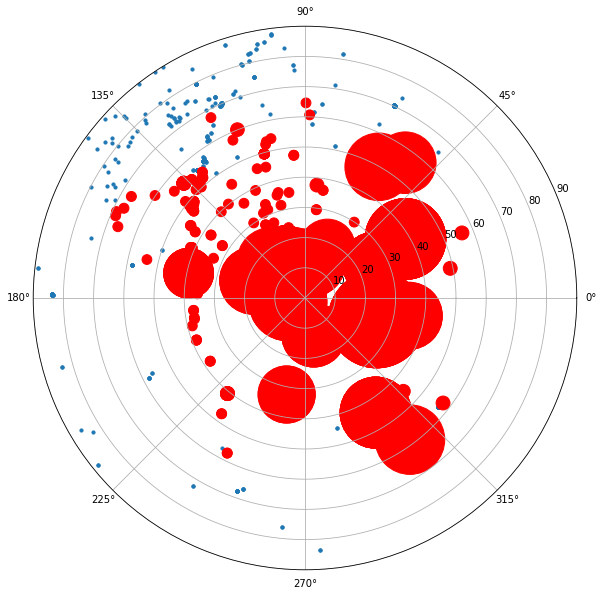

1422 0.010692983417107884 179.9546625 -0.6493333333333333 A FORS2
1423 0.010692983417107884 179.9546625 -0.6493333333333333 A FORS2
1424 0.010692983417107884 179.9546625 -0.6493333333333333 A FORS2
1425 0.010692983417107884 179.9546625 -0.6493333333333333 A FORS2
1426 0.010692983417107884 179.9546625 -0.6493333333333333 A FORS2
1648 0.01537794649058793 205.53520833333334 9.4759775 A KMOS
1649 0.01537794649058793 205.53520833333334 9.4759775 A KMOS
1650 0.01537794649058793 205.53520833333334 9.4759775 A KMOS
1645 0.015378951642795449 205.53298333333333 9.473783055555556 A KMOS
1646 0.015378951642795449 205.53298333333333 9.473783055555556 A KMOS
1647 0.015378951642795449 205.53298333333333 9.473783055555556 A KMOS
1651 0.015379269704297564 205.53227916666665 9.47308861111111 A KMOS
1374 0.016494958869492853 185.38794166666668 -30.17135 A FORS2
1399 0.016494958869492853 185.38794166666668 -30.17135 A FORS2
1405 0.016494958869492853 185.38794166666668 -30.17135 A FORS2
24907 0.01981044839

<Figure size 432x288 with 0 Axes>

In [14]:
global paranal, paranalObserver

paranalObserver = Observer(longitude=-70.4039*u.deg, latitude=-24.6272*u.deg, elevation=2635*u.m, name="Paranal", timezone="Chile/Continental")
paranal =EarthLocation(lon=-70.4039*u.deg, lat=-24.6272*u.deg, height=2635*u.m)



def rank(dateofnight, isottimenow, currenttransparency, currentseeing , plottingbool=False):

    #dateofnight='2022-05-11'
    #isottimenow='2022-05-12T03:20:00'
    time = Time(isottimenow, format='isot', scale='utc')    ##.to_value('jd')
    JDtimenow=time.jd

    #JDtimenow='2459217.45'
    #time = Time(JDtimenow, format='jd', scale='utc')
    #print(moon_phase_angle(time))
    #print(moon_illumination(time))

    ### moon phase and position
    current_fli=moon_illumination(time)
    MoonSC=get_moon(time, location=paranal, ephemeris='de432s')
    MoonSCaltaz=MoonSC.transform_to(AltAz(obstime=time, location=paranal))

    


    eveningtwilightt=float(paranalObserver.twilight_evening_astronomical(time, which='next', n_grid_points=150).jd)
    morningtwilightt=float(paranalObserver.twilight_morning_astronomical(time, which='next', n_grid_points=150).jd)
    #print(eveningtwilightt)



    cobj = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
    cobjaltazs = cobj.transform_to(AltAz(obstime=time, location=paranal))

    currentAirmass=np.array(cobjaltazs.secz)
    currentAlt=np.array(cobjaltazs.alt.deg)
    currentAz=np.array(cobjaltazs.az.deg)


    #seeing=seeing.astype('float')
    #sky_transparency=sky_transparency.astype('str')
    #currenttransparency 


    pos=np.where( (currentAlt>0) & ((OBstatus=='+') | (OBstatus=='M')   ) &  ( (instrument=='FORS2')  |  (instrument=='KMOS')    )  )
    #print (currentAirmass[pos])
    #print('pos', pos)
    #print(sky_transparency[pos])

    ######## transaprency filtering   ##############
    postransparency=np.array([])
    if currenttransparency == 'PHO':
        postransparency=np.where( (sky_transparency[pos]=='1PHO') | (sky_transparency[pos]=='2CLR') | (sky_transparency[pos]=='3THN') | (sky_transparency[pos]=='4THK'))
    if currenttransparency == 'CLR':
        postransparency=np.where( (sky_transparency[pos]=='2CLR') | (sky_transparency[pos]=='3THN') | (sky_transparency[pos]=='4THK'))
    if currenttransparency == 'THN':
        postransparency=np.where( (sky_transparency[pos]=='3THN') | (sky_transparency[pos]=='4THK'))
    if currenttransparency == 'THK':
        postransparency=np.where(  (sky_transparency[pos]=='4THK'))
    #print('postransparency', postransparency)

    if len(postransparency)==0:
        ranking=np.array([])
        pos2a=np.array([])
        return pos2a, ranking

    pos=pos[0][postransparency[0]]
    #print ('pos2', pos)



    #target_set_time = paranalObserver.target_set_time(time, cobj[pos], which="next") 
    #print(target_set_time.iso[12])
    #print("ISO: {0.iso}, JD: {0.jd}".format(target_set_time)) 

    #print(time.iso)
    #print(execution_time[12])


    ### calculate airmass at end of OB for all visible targets, and moon distance
    targetseczatend=[]
    currentmoondist=[]
    for i in range(0,len(pos)):
        targetseczatend.append( targetAiramssAtEndOfOB(ra[pos][i], dec[pos][i],JDtimenow,execution_time[i]) ) 
        if MoonSCaltaz.alt.deg > 0:
            currentmoondist.append(  MoonDistance(MoonSC, ra[pos][i], dec[pos][i]) ) 
    
    targetseczatend=np.array(targetseczatend)
    currentmoondist=np.array(currentmoondist)



    if MoonSCaltaz.alt.deg > 0:
        pos2=np.where( (currentAirmass[pos]<airmass[pos]) & (targetseczatend<airmass[pos])  & (currentmoondist>moon_distance[pos])  & (current_fli<fli[pos])  )
        #print('pos2', pos2)
    else:
        pos2=np.where( (currentAirmass[pos]<airmass[pos]) & (targetseczatend<airmass[pos])  )
        #print('pos2', pos2)


    pos2a=pos[pos2[0]]



    ############ SEEING constraint  #########################

    ###currentseeing=  precast10min(starttime)   ### goes into simulation loop

    #### this is the current IQ for the particular OB
    currentIQ=[]
    for i in range(0,len(pos2a)):
        instr=instrument[pos2a][i]
        if instr == 'FORS2':
            insfilter='R_SPECIAL'
        if instr == 'KMOS':
            insfilter='H,H,H'
        if instr=='XSHOOTER':
            insfilter='R'


        currentIQ.append(  FWHMIQ(currentseeing, instr, insfilter, currentAirmass[pos2a][i])  ) 
    currentIQ=np.array(currentIQ)   

    #print('seeinlim', seeing[pos2a])
    #print('currentIQ', currentIQ)

    pos3=np.where( (currentIQ<seeing[pos2a])  )

    #print(pos3)
      
    pos2a=pos2a[pos3[0]]

    #FWHMIQ(0.83, 'FORS2', 'R_SPECIAL', 1.1)
    #FWHMIQ(0.83, 'KMOS', 'H,H,H', 1.1)



    ##### check that OB ends before twilight

    targduration=execution_time[pos2a]/(3600*24)
    targendjd=JDtimenow+targduration
    pos4=np.where( targendjd < morningtwilightt   )
    pos2a=pos2a[pos4[0]]




    ##### ranking of targets

    #currenttransparency='CLR'
    #currentseeing=0.5

    ranking=[]
    for i in range(0,len(pos2a)):
        index=pos2a[i]
        #print(index, ra[index], dec[index], rank_class[index])
        #print(    Psky(currenttransparency),    Pz(airmass[index],  dec[index]),    Pset(airmass[index], ra[index], dec[index], dateofnight),    interpolatePseeing(currentseeing),    interpolatePfli(current_fli) )
    #    Psky(currenttransparency)
    #    Pz(airmass[index],  dec[index])
    #    Pset(airmass[index], ra[index], dec[index], dateofnight)
    #    interpolatePseeing(currentseeing)
    #    interpolatePfli(current_fli)

        probability= Psky(currenttransparency)  *  Pz(airmass[index],  dec[index]) *   Pset(airmass[index], ra[index], dec[index], dateofnight)*   interpolatePseeing(currentseeing)*   interpolatePfli(current_fli) 

        if rank_class[index]=='B':
            probability=probability+0.5
        if rank_class[index]=='C':
            probability=probability+1.0

        ranking.append(probability)

    ranking=np.array(ranking)
    ###print(ranking)
    #print(pos2a)

    if len(ranking)!=0:
        ranking, pos2a = zip(*sorted(zip(ranking, pos2a)))


    ranking=np.array(ranking)
    pos2a=np.array(pos2a)
    #print(ranking)
    #print(pos2a)






    #### plotting

    if plottingbool==True:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='polar')
        #plt.xlim(0,360)
        plt.ylim(0,90)
        ax.scatter(currentAz[pos]*(np.pi/180.0), 90-currentAlt[pos], s=10)                      #c=currentAirmass[pos], cmap='jet'
        ax.scatter(currentAz[pos2a]*(np.pi/180.0), 90-currentAlt[pos2a], s=100*1.0/ranking, c='r')           #c=currentAirmass[pos], cmap='jet'

        ax.scatter(MoonSCaltaz.az.deg*(np.pi/180.0), 90-MoonSCaltaz.alt.deg, s=300, c='gray')   #c=currentAirmass[pos], cmap='jet'
        #ax.scatter(90*(np.pi/180.0), 90-30, s=40)
        plt.savefig(str(isottimenow)+'.png')
        plt.show()
        plt.clf()


    return pos2a, ranking


pos2a, ranking= rank(dateofnight='2021-02-19', isottimenow='2021-02-20T07:08:22.300', currenttransparency='CLR', currentseeing=0.4, plottingbool=True )

#pos2a= rank('2022-05-11', '2022-05-12T03:20:00', 'CLR', 0.5 )


for i in range(0, len(pos2a)):
    index= pos2a[i]
    print(index, ranking[i], ra[index], dec[index], rank_class[index], instrument[index])




2021-04-01
eveningtwilightt 2021-04-01T23:55:29.658
morningtwilightt 2021-04-02T09:35:12.127


/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


3207356 2021-04-01T23:55:29.658 2021-04-02T00:55:30.658 3601.0 C A 0.9 FORS2 1.0705314421295884 0.0 0.0 0.66 0.79
3207372 2021-04-02T00:55:30.658 2021-04-02T01:55:30.658 3600.0 C A 0.9 FORS2 1.2121591264474327 0.0 0.0 0.58 0.7
instrument change to KMOS
3272387 2021-04-02T02:02:30.658 2021-04-02T03:00:49.658 3499.0 C A 1.9 KMOS 1.4815315881652797 0.0 0.0 0.65 0.71
2889137 2021-04-02T03:00:49.658 2021-04-02T04:00:31.658 3582.0 C A 0.8 KMOS 1.2994762186487996 0.02 0.01 0.57 0.96
3272535 2021-04-02T04:00:31.658 2021-04-02T04:58:50.658 3499.0 C A 1.9 KMOS 1.2294103449681086 0.0 0.0 0.71 0.87
instrument change to FORS2
3278103 2021-04-02T05:05:50.658 2021-04-02T05:39:09.658 1999.0 C A 2.0 FORS2 1.4281150319316198 0.0 0.0 1.23 1.15
3278445 2021-04-02T05:39:09.658 2021-04-02T06:12:28.658 1999.0 C A 2.0 FORS2 1.3963339242454829 0.0 0.0 1.0 1.21
instrument change to KMOS
3272538 2021-04-02T06:19:28.658 2021-04-02T07:17:47.658 3499.0 C A 1.9 KMOS 1.331751138552893 0.0 0.0 0.8 0.82
3272541 2021-04

/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:330: UserWarning: FixedFormatter should only be used together with FixedLocator


2021-04-02
eveningtwilightt 2021-04-02T23:54:30.340
morningtwilightt 2021-04-03T09:35:36.032


/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


3207389 2021-04-02T23:54:30.340 2021-04-03T00:54:30.340 3600.0 C B 0.9 FORS2 1.0753373931413295 0.11 0.04 0.71 1.08
3209261 2021-04-03T00:54:30.340 2021-04-03T01:54:31.340 3601.0 C A 0.9 FORS2 1.2218805861643343 0.09 0.0 0.72 0.68
instrument change to KMOS
3272390 2021-04-03T02:01:31.340 2021-04-03T02:59:50.340 3499.0 C A 1.9 KMOS 1.4871750627152407 0.0 0.0 0.5 0.65
3013040 2021-04-03T02:59:50.340 2021-04-03T03:59:53.340 3603.0 C A 0.6 KMOS 1.3155498476037657 0.0 0.0 0.42 0.55
3272433 2021-04-03T03:59:53.340 2021-04-03T04:58:12.340 3499.0 C A 1.9 KMOS 1.2258809278680323 0.0 0.0 0.55 0.59
instrument change to FORS2
3088355 2021-04-03T05:05:12.340 2021-04-03T05:59:25.340 3253.0 C A 1.0 FORS2 2.0801564446740723 0.0 0.0 0.69 0.64
instrument change to KMOS
3272436 2021-04-03T06:06:25.340 2021-04-03T07:04:44.340 3499.0 C A 1.9 KMOS 1.307422458184442 0.0 0.0 0.54 0.59
3272439 2021-04-03T07:04:44.340 2021-04-03T08:03:03.340 3499.0 C A 1.9 KMOS 1.5295768730074482 0.0 0.0 0.68 0.62
instrument ch

/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:330: UserWarning: FixedFormatter should only be used together with FixedLocator


2021-04-03
eveningtwilightt 2021-04-03T23:53:31.556
morningtwilightt 2021-04-04T09:35:59.735


/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


3248033 2021-04-03T23:53:31.556 2021-04-04T00:38:56.556 2725.0 C A 1.3 FORS2 1.3047767815101576 0.0 0.0 0.62 0.54
3248036 2021-04-04T00:38:56.556 2021-04-04T01:24:21.556 2725.0 C A 1.3 FORS2 1.2807654619326676 0.0 0.0 0.83 0.83
instrument change to KMOS
3272393 2021-04-04T01:31:21.556 2021-04-04T02:29:40.556 3499.0 C A 1.9 KMOS 1.4484645159259868 0.0 0.0 0.54 0.76
3272088 2021-04-04T02:29:40.556 2021-04-04T03:27:59.556 3499.0 C A 1.9 KMOS 1.572892485053452 0.0 0.0 0.66 0.54
3272667 2021-04-04T03:27:59.556 2021-04-04T04:08:19.556 2420.0 C A 1.9 KMOS 1.3035194802478767 0.0 0.0 0.55 0.8
3013043 2021-04-04T04:08:19.556 2021-04-04T05:08:22.556 3603.0 C B 0.6 KMOS 1.7394312018507914 0.17 0.0 0.54 0.59
2869499 2021-04-04T05:08:22.556 2021-04-04T06:09:18.556 3656.0 M C 1.0 KMOS 2.6674467065629166 0.48 0.34 1.0 0.64
instrument change to FORS2
3206280 2021-04-04T06:16:18.556 2021-04-04T06:47:57.556 1899.0 C A 1.4 FORS2 1.731170283624801 0.0 0.0 1.01 1.06
3206283 2021-04-04T06:47:57.556 2021-04-0

/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:330: UserWarning: FixedFormatter should only be used together with FixedLocator


2021-04-04
eveningtwilightt 2021-04-04T23:52:33.330
morningtwilightt 2021-04-05T09:36:23.252


/Users/acikota/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


3209264 2021-04-04T23:52:33.330 2021-04-05T00:52:33.330 3600.0 M C 0.9 FORS2 1.0856219061911463 0.67 0.53 1.02 0.8
3214868 2021-04-05T00:52:33.330 2021-04-05T01:27:17.330 2084.0 C A 1.5 FORS2 1.2754312624652426 0.0 0.0 1.16 1.55
instrument change to KMOS
3272091 2021-04-05T01:34:17.330 2021-04-05T02:32:36.330 3499.0 C A 1.9 KMOS 1.4561110382799092 0.0 0.0 0.77 0.86
3272317 2021-04-05T02:32:36.330 2021-04-05T03:30:55.330 3499.0 C A 1.9 KMOS 1.5977167344991323 0.0 0.0 0.87 0.86
instrument change to FORS2
3288922 2021-04-05T03:37:55.330 2021-04-05T04:37:55.330 3600.0 C A 1.0 FORS2 1.1200552724836719 0.01 0.0 0.8 0.94
3288928 2021-04-05T04:37:55.330 2021-04-05T05:37:55.330 3600.0 M C 1.0 FORS2 1.2328227958121492 0.75 0.67 1.33 0.85
3215372 2021-04-05T05:37:55.330 2021-04-05T06:07:39.330 1784.0 C A 1.5 FORS2 1.027076226295138 0.07 0.0 1.29 1.71
2728325 2021-04-05T06:07:39.330 2021-04-05T06:12:35.330 296.0 C A 1.5 FORS2 1.2191983265276063 0.08 0.0 1.32 1.5
3215779 2021-04-05T06:12:35.330 202

KeyboardInterrupt: 

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

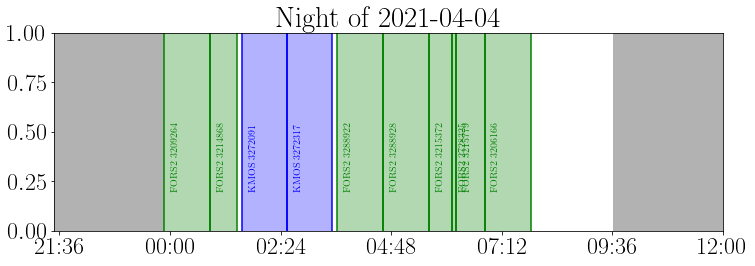

In [375]:

#### don't forget to reload OBs


#observing_log_filename = 'observing_log_precast.txt'
#observing_log_filename = 'observing_log_RF.txt'
#observing_log_filename = 'observing_log_nowcast60.txt'
#observing_log_filename = 'temp.txt'
observing_log_filename = 'observing_log_precast_2021_2022.txt'



for nightcount in range(0, 183):
    dateofnight='2021-04-01'
    #dateofnight='2021-07-25'
    time = Time(dateofnight+'T15:00:00', format='isot', scale='utc').to_value('jd')+nightcount    
    time = Time(time, format='jd', scale='utc')
    dateofnight=str(time.to_value('iso', subfmt='date'))
    print(dateofnight)


    #dateofnight='2021-04-01'
    #time = Time(dateofnight+'T15:00:00', format='isot', scale='utc')    ##.to_value('jd')

    eveningtwilightt=paranalObserver.twilight_evening_astronomical(time, which='next', n_grid_points=150)
    morningtwilightt=paranalObserver.twilight_morning_astronomical(time, which='next', n_grid_points=150)
    sunsettime= paranalObserver.sun_set_time(time, which='next', n_grid_points=150)
    sunrisetime=paranalObserver.sun_rise_time(time, which='next', n_grid_points=150)

    print('eveningtwilightt', eveningtwilightt.isot)
    print('morningtwilightt', morningtwilightt.isot)

    #eveningtwilightt=float(eveningtwilightt.jd)
    #morningtwilightt=float(morningtwilightt.jd)

    ##### plot begining 

    fig = plt.figure(figsize=(12,8))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=24)
    plt.rc('xtick', labelsize=24)
    plt.rc('ytick', labelsize=24)
    plt.rc('axes', labelsize=24)



    ax = fig.add_subplot(211)
    plt.title('Night of '+ str(time.to_value('iso', subfmt='date') ))


    polygon = plt.Polygon([[eveningtwilightt.jd-0.1, 0], [eveningtwilightt.jd, 0], [eveningtwilightt.jd, 1], [eveningtwilightt.jd-0.1, 1], [eveningtwilightt.jd-0.1, 0]])
    ax.add_patch(polygon)
    polygon.set_facecolor('black')
    polygon.set_alpha(0.3)

    polygon = plt.Polygon([[morningtwilightt.jd, 0], [morningtwilightt.jd+0.1, 0], [morningtwilightt.jd+0.1, 1], [morningtwilightt.jd, 1], [morningtwilightt.jd, 0]])
    ax.add_patch(polygon)
    polygon.set_facecolor('black')
    polygon.set_alpha(0.3)


    plt.ylim(0,1)
    plt.xlim(eveningtwilightt.jd-0.1, morningtwilightt.jd+0.1)

    #print(ax.get_xticks())
    tickstime = Time(ax.get_xticks(), format='jd', scale='utc').to_value('iso', subfmt='date_hms') 
    #print(tickstime)
    for i in range(0,len(tickstime)):
        tickstime[i]=tickstime[i].split()[1][:tickstime[i].split()[1].rfind(':')]
    #print(tickstime)

    #def jdticktoisotime()
    #str(time.to_value('iso', subfmt='date') 

    #ax.set_xticks([0,2,4,6])
    ax.set_xticklabels(tickstime)



    ##### plot beginining 





    currenttime=eveningtwilightt
    currentinstrument='FORS2'
    firstOBofnight=True
    #print('currenttime', currenttime.isot)
    #pos2a,  ranking= rank(dateofnight=dateofnight, isottimenow=str(currenttime.isot), currenttransparency='CLR', currentseeing=0.5 )


    #pos2a,  ranking= rank(dateofnight='2022-05-11', isottimenow='2022-05-11T23:26:00.744', currenttransparency='CLR', currentseeing=0.5 )
    #print(pos2a)


    while currenttime < morningtwilightt: #Time('2022-05-12T00:50:09.707', format='isot', scale='utc'): ## morningtwilightt:

        currentseeing=  precast10min(currenttime.isot)
        #currentseeing=nowcastRT(currenttime.isot)[0]
        #currentseeing=nowcast60(currenttime.isot)[0]
        if str(currentseeing)=='nan':
            currentseeing=0.7


        currenttransparency=current_transparency(currenttime.jd)

        #print ('current: time, seeing, transaprecny, instrument', currenttime.isot, currentseeing, currenttransparency, currentinstrument)

        pos2a, ranking = rank(dateofnight=dateofnight, isottimenow=str(currenttime.isot), currenttransparency=currenttransparency, currentseeing=currentseeing , plottingbool=False)
        #print(pos2a)

        if len(pos2a) == 0:
            currenttime= Time(currenttime+(10.0/60.0/24.0), format='jd', scale='utc')   ### idle 10min
            print('idle', currenttime.isot)
            
            f=open(observing_log_filename ,'a')
            f.write('IDLE'+','+str(Time(currenttime-(10.0/60.0/24.0), format='jd', scale='utc').to_value('isot'))+','+str( currenttime.isot)+','+str( 10.0*60.0)+','+str(currenttransparency)+'\n' )
            f.close()
            continue
            

        
        index=pos2a[0]

        ### instrument change 

        if (instrument[index]!=currentinstrument):
            if len(pos2a)==1:
                if firstOBofnight==False:
                    currenttime= Time(currenttime+(7.0/60.0/24.0), format='jd', scale='utc')   ### change instrument
                currentinstrument=instrument[index]
                print('instrument change to', currentinstrument)
                
                f=open(observing_log_filename ,'a')
                f.write('ChangeOfFocus'+','+str(Time(currenttime-(7.0/60.0/24.0), format='jd', scale='utc').to_value('isot'))+','+str( currenttime.isot)+','+str( 7.0*60.0)+','+str(currentinstrument)+'\n' )
                f.close()


            if len(pos2a)>=2:
                for j in range(1, len(pos2a)):        
                    if (instrument[pos2a[j]]==currentinstrument) and (ranking[j]-ranking[0]<0.2):
                        index=pos2a[j]
                        break
                    if (instrument[pos2a[j]]!=currentinstrument) and (ranking[j]-ranking[0]<0.2):
                        if firstOBofnight==False:
                            currenttime= Time(currenttime+(7.0/60.0/24.0), format='jd', scale='utc')   ### change instrument
                        currentinstrument=instrument[index]
                        print('instrument change to', currentinstrument)
                        
                        f=open(observing_log_filename ,'a')
                        f.write('ChangeOfFocus'+','+str(Time(currenttime-(7.0/60.0/24.0), format='jd', scale='utc').to_value('isot'))+','+str( currenttime.isot)+','+str( 7.0*60.0)+','+str(currentinstrument)+'\n' )
                        f.close()
                        break



        firstOBofnight=False

        targstart=currenttime
        targduration=execution_time[index]/(3600*24)

        targstartjd = Time(targstart, format='isot', scale='utc').to_value('jd')
        targendjd=targstartjd+targduration


        ### plot OB block
        polygon = plt.Polygon([[targstartjd, 0], [targendjd, 0], [targendjd, 1], [targstartjd, 1], [targstartjd, 0]])
        ax.add_patch(polygon)
        
        if instrument[index]=='FORS2':
            polygon.set_facecolor('green')
            polygon.set_alpha(0.3)
            ax.axvline(x=targstartjd, color='green', linestyle='-')
            ax.axvline(x=targendjd, color='green', linestyle='-')
            ax.text(targstartjd+0.005, 0.2, str(instrument[index])+' '+str(ob_id[index]), fontsize=10, rotation=90, color='green')

        if instrument[index]=='KMOS':
            polygon.set_facecolor('blue')
            polygon.set_alpha(0.3)
            ax.axvline(x=targstartjd, color='blue', linestyle='-')
            ax.axvline(x=targendjd, color='blue', linestyle='-')
            ax.text(targstartjd+0.005, 0.2, str(instrument[index])+' '+str(ob_id[index]), fontsize=10, rotation=90, color='blue')

        if instrument[index]=='XSHOOTER':
            polygon.set_facecolor('red')
            polygon.set_alpha(0.3)
            ax.axvline(x=targstartjd, color='red', linestyle='-')
            ax.axvline(x=targendjd, color='red', linestyle='-')
            ax.text(targstartjd+0.005, 0.2, str(instrument[index])+' '+str(ob_id[index]), fontsize=10, rotation=90, color='red')

        ### block

        currenttime= Time(targendjd, format='jd', scale='utc')


        ############ OB grading  ##########

        instr=instrument[index]
        if instr == 'FORS2':
            insfilter='R_SPECIAL'
        if instr == 'KMOS':
            insfilter='H,H,H'
        if instr=='XSHOOTER':
            insfilter='R'


        cobj = SkyCoord(ra[index], dec[index], unit=(u.deg, u.deg), frame='icrs')
        cobjaltazs = cobj.transform_to(AltAz(obstime=Time(targendjd, format='jd', scale='utc').to_value('isot'), location=paranal))
        targAirmassAtEnd =cobjaltazs.secz

        
        #print(Time(targstartjd, format='jd', scale='utc').to_value('isot'), Time(targendjd, format='jd', scale='utc').to_value('isot'), seeing[index], instr, insfilter, targAirmassAtEnd)
        dimmavg,dimmstd,dimmmin,dimmmax,duration,aboveAreqduration,aboveBreqduration,aboveAreqdurationfrac, aboveBreqdurationfrac, precast10minf= obDIMM2IQanalysis(Time(targstartjd, format='jd', scale='utc').to_value('isot'), Time(targendjd, format='jd', scale='utc').to_value('isot'), seeing[index], instr, insfilter, targAirmassAtEnd, plotbool=False)

        if aboveAreqdurationfrac<=0.1:
            grstatus='C'
            grgrade='A'
        
        if aboveAreqdurationfrac>0.1:
            grstatus='C'
            grgrade='B'

        if aboveBreqdurationfrac>0.1:
            grstatus='M'
            grgrade='C'




        ### check if transaprecy fulfilled
        transparencyatend=current_transparency(targendjd)
        transparencyrequirement=sky_transparency[index]

        if (transparencyrequirement == '1PHO') and (transparencyatend != 'PHO'):
            grstatus='M'
            grgrade='C'
        
        if (transparencyrequirement == '2CLR') and (  (transparencyatend != 'PHO') and  (transparencyatend != 'CLR')  ): 
            grstatus='M'
            grgrade='C'

        if (transparencyrequirement == '3THN') and (  (transparencyatend != 'PHO') and  (transparencyatend != 'CLR') and (transparencyatend != 'THN')  ): 
            grstatus='M'
            grgrade='C'

        if (transparencyrequirement == '4THK') and (  (transparencyatend != 'PHO') and  (transparencyatend != 'CLR') and (transparencyatend != 'THN') and (transparencyatend != 'THK') ): 
            grstatus='M'
            grgrade='C'




        OBstatus[index]=grstatus
        OBgrade[index]=grgrade
        #print ('obstatus, grade, seeingrequirement, instr, insfilter, aboveAreqdurationfrac, aboveBreqdurationfrac: ', Time(targstartjd, format='jd', scale='utc').to_value('isot'), Time(targendjd, format='jd', scale='utc').to_value('isot'), grgrade, seeing[index], instr, insfilter, targAirmassAtEnd, aboveAreqdurationfrac, aboveBreqdurationfrac)

        print (ob_id[index], Time(targstartjd, format='jd', scale='utc').to_value('isot'), Time(targendjd, format='jd', scale='utc').to_value('isot'), execution_time[index], grstatus, grgrade, seeing[index], instr, targAirmassAtEnd, aboveAreqdurationfrac, aboveBreqdurationfrac, dimmavg, precast10minf)

        f=open(observing_log_filename ,'a')
        f.write(str(ob_id[index])+','+str(Time(targstartjd, format='jd', scale='utc').to_value('isot'))+','+str( Time(targendjd, format='jd', scale='utc').to_value('isot'))+','+str( execution_time[index])+','+str( grstatus)+','+str( grgrade)+','+str( seeing[index])+','+str( instr)+','+str( targAirmassAtEnd)+','+str( aboveAreqdurationfrac)+','+str( aboveBreqdurationfrac)+','+str( dimmavg)+','+str( precast10minf) +','+str(rank_class[index])+'\n' )
        f.close()



    ### plot end

    fig.canvas.draw()
    #ax.set_xlabels(['two', 'four','six', 'eight', 'ten'])
    #print(ax.get_xticklabels())
    ax2 = fig.add_subplot(212)

    dimmindex=np.where((dimmtjd>eveningtwilightt.jd) & (dimmtjd<morningtwilightt.jd))



    sunsettime=eveningtwilightt.jd
    sunrisetime=morningtwilightt.jd
    indli=np.where((transparency_start_ut_jd > sunsettime-1 ) & (transparency_end_ut_jd < sunrisetime+1 ) )[0]
    for ind in indli:    
        if transparency_CY[ind]==1:
            transparency='CY'
        if transparency_WI[ind]==1:
            transparency='WI'
        if transparency_HU[ind]==1:
            transparency='HU'
        if transparency_RN[ind]==1:
            transparency='RN'
        if transparency_SN[ind]==1:
            transparency='SN'
        if transparency_EQ[ind]==1:
            transparency='EQ'
        if transparency_OT[ind]==1:
            transparency='OT'
        ### note that previous transaprency gets overwritten if more than one condition is fulfilled (e.g. WI and CLR)
        if transparency_PH[ind]==1:
            transparency='PHO'
        if transparency_CL[ind]==1:
            transparency='CLR' 
        if transparency_TN[ind]==1:
            transparency='THN'
        if transparency_TK[ind]==1:
            transparency='THK'

        print(transparency_start_ut_jd[ind], transparency_end_ut_jd[ind], transparency)

        polygon = plt.Polygon([[transparency_start_ut_jd[ind], 0], [transparency_end_ut_jd[ind], 0], [transparency_end_ut_jd[ind], 0.2], [transparency_start_ut_jd[ind], 0.2], [transparency_start_ut_jd[ind], 0.2]])
        ax2.add_patch(polygon)
        
        if (transparency=='PHO') or (transparency=='CLR') or(transparency=='THN') or (transparency=='THK'):
            polygon.set_facecolor('green')
            polygon.set_alpha(0.3)
            #ax.axvline(x=targstartjd, color='green', linestyle='-')
            #ax.axvline(x=targendjd, color='green', linestyle='-')
            ax2.text(transparency_start_ut_jd[ind]+0.02, 0.05, str(transparency), fontsize=12, rotation=0, color='green')

        else:
            polygon.set_facecolor('black')
            polygon.set_alpha(0.3)
            #ax.axvline(x=targstartjd, color='green', linestyle='-')
            #ax.axvline(x=targendjd, color='green', linestyle='-')
            ax2.text(transparency_start_ut_jd[ind]+0.02, 0.05, str(transparency), fontsize=12, rotation=0, color='black')





    ax2.plot(dimmtjd[dimmindex], dimm[dimmindex])
    plt.xlim(eveningtwilightt.jd-0.1, morningtwilightt.jd+0.1)
    ax2.set_xticklabels(tickstime)





    #### altitude plot
    paranalObserver = Observer(longitude=-70.4039*u.deg, latitude=-24.6272*u.deg, elevation=2635*u.m, name="Paranal", timezone="Chile/Continental")
    paranal =EarthLocation(lon=-70.4039*u.deg, lat=-24.6272*u.deg, height=2635*u.m)

    moonalt=[]
    moonalttime=[]
    targalt=[]
    moondistarr=[]

    for JD in np.arange(eveningtwilightt.jd-0.1, morningtwilightt.jd+0.1, 0.005):
        JDtimenow=JD

        time = Time(JDtimenow, format='jd', scale='utc')

        ### moon phase and position
        current_fli=moon_illumination(time)
        MoonSC=get_moon(time, location=paranal, ephemeris='de432s')
        MoonSCaltaz=MoonSC.transform_to(AltAz(obstime=time, location=paranal))
            
        moonalt.append(MoonSCaltaz.alt.deg)
        moonalttime.append(JDtimenow)

    #ax.set_ylim(0.0001,35)

    ax4 = ax2.twinx()
    ax4.plot(moonalttime, moonalt, 'k--', alpha=0.5, zorder=-100)

    ax4.set_ylim(0.0,90)

    if max(moonalt)>0:
        ax4.text(morningtwilightt.jd+0.02, 80, 'FLI='+str(round(current_fli,2)), fontsize=18, color='gray')







    plt.xlabel('UTC Time')
    #plt.show()
    plt.savefig('output/'+dateofnight+'.png')
    plt.clf()



In [340]:

totaltime=0

intall=np.where((instrument=='FORS2') | (instrument=='KMOS') | (instrument=='XSHOOTER') & ((rank_class=='A' ) | (rank_class=='B' )) )

for i in intall[0]:
    totaltime=totaltime +execution_time[i]

print(totaltime/3600)



totaltime=0
intall=np.where( ((instrument=='FORS2') | (instrument=='KMOS') | (instrument=='XSHOOTER')) & (OBstatus=='C')  & ((rank_class=='A' ) | (rank_class=='B' )) )
for i in intall[0]:
    totaltime=totaltime +execution_time[i]


print(totaltime/3600)

1321.278611111111
720.33


## PLOT results

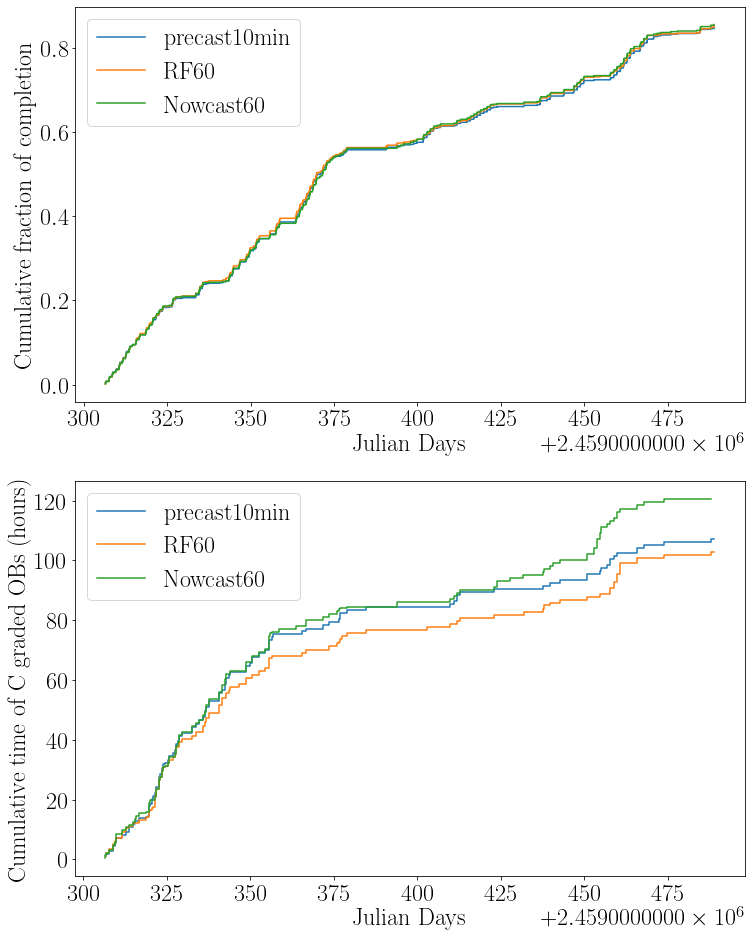

In [288]:
timearr=[]
cumulativesumarr=[]
cummulativesum=0
timearr_mustrepeat=[]
cumulativesumarr_mustrepeat=[]
cummulativesum_mustrepeat=0



f=open('observing_log_precast.txt','r')
#f=open('observing_log_RF.txt','r')
for line in f:
    line=line.split(',')

    if line[0]!='IDLE' and line[0]!='ChangeOfFocus':

        tend=line[2]
        tendjd=Time(tend, format='isot', scale='utc').to_value('jd')

        duration=float(line[3])
        grstatus=line[4]
        grgrade=line[5]
        
        if grstatus=='C':
            cummulativesum=cummulativesum+duration
            timearr.append(tendjd)
            cumulativesumarr.append(cummulativesum/3600/608.917778)

        if grstatus=='M':
            cummulativesum_mustrepeat=cummulativesum_mustrepeat+duration
            timearr_mustrepeat.append(tendjd)
            cumulativesumarr_mustrepeat.append(cummulativesum_mustrepeat/3600)


    #f.write(str(ob_id[index])+','+str(Time(targstartjd, format='jd', scale='utc').to_value('isot'))+','+str( Time(targendjd, format='jd', scale='utc').to_value('isot'))+','+str( execution_time[index])+','+str( grstatus)+','+str( grgrade)+','+str( seeing[index])+','+str( instr)+','+str( targAirmassAtEnd)+','+str( aboveAreqdurationfrac)+','+str( aboveBreqdurationfrac)+','+str( dimmavg)+','+str( precast10minf) +'\n' )
f.close()





timearrRF=[]
cumulativesumarrRF=[]
cummulativesumRF=0
timearrRF_mustrepeat=[]
cumulativesumarrRF_mustrepeat=[]
cummulativesumRF_mustrepeat=0

#f=open('observing_log.txt','r')
f=open('observing_log_RF.txt','r')
for line in f:
    line=line.split(',')

    if line[0]!='IDLE' and line[0]!='ChangeOfFocus':

        tend=line[2]
        tendjd=Time(tend, format='isot', scale='utc').to_value('jd')

        duration=float(line[3])
        grstatus=line[4]
        grgrade=line[5]
        
        if grstatus=='C':
            cummulativesumRF=cummulativesumRF+duration
            timearrRF.append(tendjd)
            cumulativesumarrRF.append(cummulativesumRF/3600/608.917778)

        if grstatus=='M':
            cummulativesumRF_mustrepeat=cummulativesumRF_mustrepeat+duration
            timearrRF_mustrepeat.append(tendjd)
            cumulativesumarrRF_mustrepeat.append(cummulativesumRF_mustrepeat/3600)

    #f.write(str(ob_id[index])+','+str(Time(targstartjd, format='jd', scale='utc').to_value('isot'))+','+str( Time(targendjd, format='jd', scale='utc').to_value('isot'))+','+str( execution_time[index])+','+str( grstatus)+','+str( grgrade)+','+str( seeing[index])+','+str( instr)+','+str( targAirmassAtEnd)+','+str( aboveAreqdurationfrac)+','+str( aboveBreqdurationfrac)+','+str( dimmavg)+','+str( precast10minf) +'\n' )
f.close()







timearr_nowcast60=[]
cumulativesumarr_nowcast60=[]
cummulativesum_nowcast60=0
timearr_nowcast60_mustrepeat=[]
cumulativesumarr_nowcast60_mustrepeat=[]
cummulativesum_nowcast60_mustrepeat=0

#f=open('observing_log.txt','r')
f=open('observing_log_nowcast60.txt','r')
for line in f:
    line=line.split(',')

    if line[0]!='IDLE' and line[0]!='ChangeOfFocus':

        tend=line[2]
        tendjd=Time(tend, format='isot', scale='utc').to_value('jd')

        duration=float(line[3])
        grstatus=line[4]
        grgrade=line[5]
        
        if grstatus=='C':
            cummulativesum_nowcast60=cummulativesum_nowcast60+duration
            timearr_nowcast60.append(tendjd)
            cumulativesumarr_nowcast60.append(cummulativesum_nowcast60/3600/608.917778)

        if grstatus=='M':
            cummulativesum_nowcast60_mustrepeat=cummulativesum_nowcast60_mustrepeat+duration
            timearr_nowcast60_mustrepeat.append(tendjd)
            cumulativesumarr_nowcast60_mustrepeat.append(cummulativesum_nowcast60_mustrepeat/3600)

    #f.write(str(ob_id[index])+','+str(Time(targstartjd, format='jd', scale='utc').to_value('isot'))+','+str( Time(targendjd, format='jd', scale='utc').to_value('isot'))+','+str( execution_time[index])+','+str( grstatus)+','+str( grgrade)+','+str( seeing[index])+','+str( instr)+','+str( targAirmassAtEnd)+','+str( aboveAreqdurationfrac)+','+str( aboveBreqdurationfrac)+','+str( dimmavg)+','+str( precast10minf) +'\n' )
f.close()





import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(12,16))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=24)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=24)



#fig.subplots_adjust(hspace=0.0, wspace=0.0)

ax1=plt.subplot(211)
ax1.step(timearr, cumulativesumarr, label='precast10min')
ax1.step(timearrRF, cumulativesumarrRF, label='RF60')
ax1.step(timearr_nowcast60, cumulativesumarr_nowcast60, label='Nowcast60')

plt.xlabel('Julian Days')
plt.ylabel('Cumulative fraction of completion')
plt.legend()




ax1=plt.subplot(212)
ax1.step(timearr_mustrepeat, cumulativesumarr_mustrepeat, label='precast10min')
ax1.step(timearrRF_mustrepeat, cumulativesumarrRF_mustrepeat, label='RF60')
ax1.step(timearr_nowcast60_mustrepeat, cumulativesumarr_nowcast60_mustrepeat, label='Nowcast60')

plt.xlabel('Julian Days')
plt.ylabel('Cumulative time of C graded OBs (hours)')
plt.legend()


plt.savefig('comparison1.pdf', dpi=300)
plt.savefig('comparison1.png', dpi=300)
plt.show()

